In [635]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from datetime import datetime

In [636]:
data = pd.read_csv('nasd_input.csv', sep = '\t', header=None, index_col = 0, )
data.index.name = None
data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730
a,40.130,40.617,40.120,39.890,40.130,40.081,40.120,39.701,39.431,38.692,38.089,38.596,39.751,39.461,38.992,38.449,37.973,36.952,37.188,36.877,37.099,38.548,37.729,38.060,37.672,36.942,37.390,36.718,37.615,38.518,38.022,38.431,38.247,37.954,38.568,38.237,38.907,39.032,39.391,40.384,...,65.946,66.036,65.956,65.787,65.647,64.599,63.980,64.260,63.8500,64.070,64.870,65.150,65.830,65.700,66.360,66.560,66.600,66.620,67.540,66.990,66.910,66.120,66.440,66.880,67.250,67.020,67.320,67.390,67.710,67.970,67.490,68.030,68.020,68.130,68.370,68.220,68.250,68.110,67.47,66.81
aa,34.711,34.283,34.260,34.349,34.453,34.453,34.518,34.388,34.584,32.578,32.822,33.671,34.628,35.087,35.218,34.408,32.557,32.600,33.275,33.868,34.671,34.933,34.326,35.020,34.671,34.408,34.800,34.082,35.000,36.176,35.825,37.243,36.154,34.144,34.709,33.731,34.144,34.496,34.367,34.581,...,44.910,46.200,47.500,46.250,45.380,45.290,44.740,45.070,46.0800,46.620,47.650,48.310,47.910,48.250,47.490,47.070,46.890,46.940,47.530,47.710,48.240,47.770,47.750,46.540,47.930,47.930,50.080,49.520,49.150,47.910,47.420,47.780,47.700,47.460,47.120,47.290,46.970,45.890,43.33,43.01
aaba,50.880,51.150,50.020,50.650,50.860,50.530,51.220,50.510,50.170,49.130,49.210,48.590,50.230,49.720,48.800,48.300,47.510,46.230,46.470,47.630,48.180,48.890,48.950,49.440,47.990,46.460,43.730,43.990,44.690,44.700,44.040,43.540,42.940,42.570,43.070,42.960,43.920,44.420,43.530,43.650,...,67.110,67.430,66.920,66.590,67.340,64.960,64.450,65.800,65.5803,66.240,66.510,67.810,67.660,67.720,67.850,68.740,68.930,69.220,67.910,67.520,68.040,66.780,67.790,67.450,67.510,66.510,66.610,65.400,65.570,67.520,68.860,70.120,70.590,70.510,70.230,71.710,72.220,71.160,70.19,70.56
aac,29.500,29.600,29.500,29.350,29.760,29.890,30.960,30.920,30.210,29.730,29.380,28.640,29.370,30.130,29.270,29.730,29.650,28.700,30.130,29.060,28.960,29.070,27.890,28.300,27.720,26.620,26.270,25.520,25.590,27.460,27.340,28.500,28.660,28.150,27.920,27.910,28.200,29.110,29.360,29.450,...,11.000,10.200,10.740,9.540,9.770,10.130,10.150,10.230,10.2400,9.930,9.990,9.990,9.950,9.590,9.170,8.370,8.330,7.800,7.720,8.350,8.030,7.930,8.200,8.240,8.630,8.450,8.420,8.300,8.320,8.560,8.200,7.920,7.550,10.020,10.080,11.140,11.070,11.110,10.88,11.28
aal,49.295,49.422,48.811,49.997,50.512,51.377,51.932,52.135,52.408,52.379,51.563,51.534,52.164,50.571,48.198,48.994,48.032,48.032,48.422,51.280,52.173,54.041,54.137,53.903,51.221,49.211,50.783,47.714,47.363,46.176,48.081,47.546,46.899,45.326,46.806,46.357,46.640,47.136,46.766,48.032,...,45.211,44.283,45.321,46.189,46.957,47.596,47.496,46.748,47.3860,47.386,47.626,50.400,50.619,50.450,51.188,50.489,52.914,52.715,52.535,52.585,52.156,51.956,51.916,51.397,51.817,50.869,51.836,50.909,48.504,47.456,47.147,46.718,47.735,47.257,47.346,47.406,46.358,46.269,45.67,45.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aek,22.578,22.688,22.704,22.513,22.504,22.561,22.570,22.537,22.833,22.784,22.794,22.827,22.784,22.842,22.833,22.809,22.827,22.866,22.969,22.833,22.905,22.962,23.033,23.025,23.051,23.156,23.058,22.968,23.043,23.122,23.122,23.171,23.108,23.082,23.122,23.114,23.100,22.960,23.043,22.945,...,25.828,25.779,25.798,25.769,25.798,25.680,25.759,25.769,25.6800,25.779,25.710,25.769,25.896,25.945,25.857,25.818,25.903,25.818,25.887,26.004,25.847,25.955,26.004,25.985,26.151,26.093,26.151,26.053,26.073,26.083,26.230,26.280,26.280,26.310,26.260,26.285,26.310,26.380,26.36,26.32
ael,27.791,27.919,28.0

In [637]:
def get_time_series(data, index):
  ts = pd.DataFrame()
  ts ['value'] = data.iloc[[index]].transpose().iloc[:,0]
  ts['date'] = pd.date_range('2020-01-01', periods=ts.shape[0]).tolist()
  ts = ts.set_index('date')
  return ts




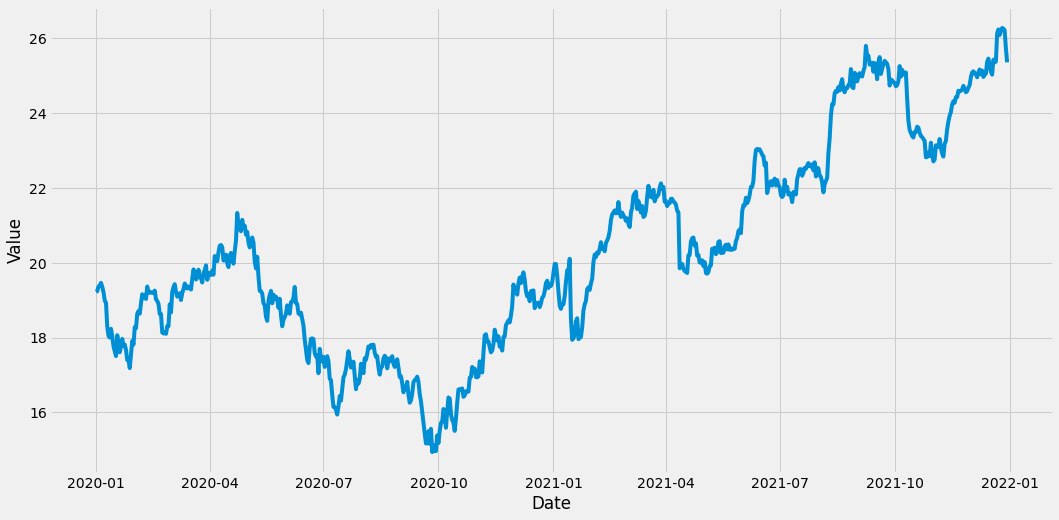

In [638]:
ts = get_time_series(data, 20)
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')
plt.plot(ts['value'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [639]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_ts = scaler.fit_transform(ts)

In [640]:
lookback = 300
forecast = 30

training_ratio = 0.7
training_size = int(training_ratio * scaled_ts.shape[0])

train_ts = scaled_ts[:training_size]
test_ts = scaled_ts[training_size-lookback:]

In [641]:
train_ts = scaled_ts[:training_size]

x_train = []
y_train = []

for i in range(lookback, len(train_ts)-forecast):
  x_train.append(train_ts[i-lookback:i, 0])
  y_train.append(train_ts[i:i+forecast, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

# x_test = []

# for i in range(lookback, len(test_ts)):
#   x_test.append(test_ts[i-lookback:i, 0])
#   break


# x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [647]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(forecast))

In [648]:
model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

In [649]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

180/180 [==============================] - 29s 136ms/step - loss: 0.0350


In [650]:
x_test = train_ts[len(train_ts)-lookback:, 0]
x_test = [x_test]

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions

TypeError: ignored

In [ ]:
train_ts = ts[:training_size].copy()
test_ts = ts[training_size:training_size+forecast].copy()
test_ts['preds'] = predictions[0]

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(train_ts['value'])
plt.plot(test_ts['value'])
plt.plot(test_ts['preds'])
plt.plot()
plt.show()



mean_absolute_error(test_ts['value'], test_ts['preds'])

test_ts